In [1]:
## GeNNus Simone & Paolo

In [31]:
import torch
import tqdm
import os
import numpy as np
from sklearn import linear_model, decomposition, datasets
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import random 
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score

In [2]:
DATASET_SIZE = "xs"
DATASET_TYPE = "waveform"

DATASET_FOLDER = f"./data/{DATASET_TYPE}"

DATASET_NUM_SAMPLES_PER_SECOND = 8000
DATASET_NUM_CHANNELS = 1

DATASET_NAME = f"fma_{DATASET_SIZE}_resampled_{DATASET_NUM_SAMPLES_PER_SECOND}_rechanneled_{DATASET_NUM_CHANNELS}"

dataset_path = f"{DATASET_FOLDER}/{DATASET_NAME}"

In [3]:
audio_path_list = []

for path, subdirs, files in os.walk(dataset_path):
    for name in files:
        file_audio_path = os.path.join(path, name)
        #print(file_audio_path)

        if name != '.DS_Store':
            audio_path_list.append(file_audio_path)

audio_path_list = sorted(audio_path_list , reverse= True)
# lista di tutti i path     

In [ ]:
single_tensors = []
labels = []

for p in audio_path_list:
    single_tensors.append(torch.load(p))
    #print(p)
    labels.append(p.split("/")[-2])

single_tensors # --> waveforms
labels # --> etichette

In [6]:
stacked_single_tensors = torch.cat(single_tensors).numpy()

(238000,)

In [19]:
data = pd.DataFrame(stacked_single_tensors)
data.insert(0, "Label", labels, True)

In [21]:

def train_test_split( dataset , perc_train , set_seed = 69):

    train = dataset.sample(frac= perc_train,random_state = set_seed )
    test  = dataset.drop(train.index)

    return (train , test )


In [22]:
train_dataset , test_dataset = train_test_split( data , perc_train = .9)

In [56]:

X = train_dataset.iloc[: , 1:]
y = train_dataset.iloc[: , :1]

std_slc = StandardScaler()

pca = decomposition.PCA()

logistic_Reg = linear_model.LogisticRegression()


pipe = Pipeline(steps=[('std_slc', std_slc),
                ('pca', pca),
                ('logistic_Reg', logistic_Reg)])


n_components = list(range( int(.50 * X.shape[0]) ,  int(.75 * X.shape[0])    , 1))


C = np.logspace(-2, 2, 20)

penalty = ['l1', 'l2']


parameters = dict(pca__n_components=n_components,
                    logistic_Reg__C=C,
                    logistic_Reg__penalty=penalty)




In [ ]:
clf = GridSearchCV(pipe, parameters)
clf.fit(X, y)

In [ ]:
print('Best Penalty:', clf.best_estimator_.get_params()['logistic_Reg__penalty'])
print('Best C:', clf.best_estimator_.get_params()['logistic_Reg__C'])
print('Best Number Of Components:', clf.best_estimator_.get_params()['pca__n_components'])
print(); print(clf.best_estimator_.get_params()['logistic_Reg'])

In [ ]:
CV_result = cross_val_score(clf , X , y , cv = 4 , n_jobs=-1)


In [55]:
pca = PCA(n_components= 60  )
pca_features = pca.fit_transform(X)
 
print('Shape before PCA: ', X.shape)
print('Shape after PCA: ', pca_features.shape)

Shape before PCA:  (81, 238000)
Shape after PCA:  (81, 60)


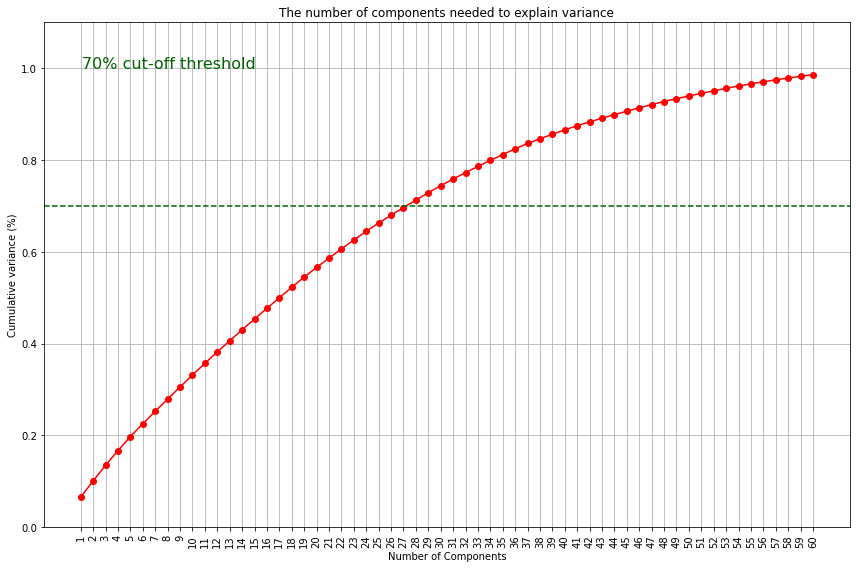

In [54]:
import matplotlib.pyplot as plt 

plt.rcParams["figure.figsize"] = (12,8)

fig, ax = plt.subplots()
xi = np.arange(1, 61, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='-', color='red')

plt.xlabel('Number of Components')
plt.xticks(np.arange(1, 61, step=1), rotation = 90) 
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.7, color='darkgreen', linestyle='--')
plt.text(1.1, 1, '70% cut-off threshold', color = 'darkgreen', fontsize=16)

ax.grid()
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split( stacked_single_tensors , labels, test_size=0.2, random_state=42 )
from sklearn.linear_model import LogisticRegression
logistic = LogisticRegression()
logistic.fit(X_train, Y_train)


In [115]:
LogisticPredictions = logistic.predict( X_test )
Logistic_Accuracy = logistic.score( X_test , Y_test) 

In [ ]:
LogisticPredictions

In [118]:
Logistic_Accuracy

0.1111111111111111

In [119]:
from sklearn.metrics import confusion_matrix
confusion_matrix( Y_test , LogisticPredictions , labels = None, sample_weight=None, normalize=None)

array([[0, 4, 0, 0, 0, 0],
       [0, 2, 0, 0, 0, 0],
       [0, 4, 0, 0, 0, 0],
       [0, 2, 0, 0, 0, 0],
       [0, 4, 0, 0, 0, 0],
       [0, 2, 0, 0, 0, 0]])

In [ ]:
from sklearn.model_selection import KFold
key_fold = KFold( n_splits=4 ) 
key_fold.get_n_splits(X_train)

In [79]:
import pandas as pd
df = pd.DataFrame(stacked_single_tensors)
X = df.iloc[:,:-1]
y = labels


In [ ]:
#Importing required libraries
from sklearn.datasets import load_breast_cancer
import pandas as pd
from sklearn.model_selection import KFold 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn import utils
from tqdm import tqdm
set.seed(69)


X = df.iloc[:,:-1]

#convert y values to categorical values

y = pd.DataFrame(labels)

#Implementing cross validation

k = 3
kf = KFold(n_splits=k, random_state= None , shuffle= True )
model = LogisticRegression()

acc_score = []

for train_index , test_index in tqdm( kf.split(X) ):

    X_train , X_test = X.iloc[train_index,:],X.iloc[test_index,:]
    y_train , y_test = y.iloc[train_index] , y.iloc[test_index]


    model.fit(X_train,y_train)
    pred_values = model.predict(X_test)

    acc = accuracy_score( pred_values , y_test)
    acc_score.append(acc)

avg_acc_score = sum(acc_score)/k


accuracy of each fold - [0.14814814814814814, 0.1111111111111111, 0.25925925925925924]
Avg accuracy : 0.1728395061728395
